In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
from sklearn.neighbors import NearestNeighbors

/home/ja/miniconda3/envs/map/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### Import DataFrames & Cleaning

In [4]:
#Import 2021 211 data
#remove the duplicate

data_211_2021 = pd.read_csv("Input_Data/2021_211_PeelYorkTO.csv", encoding='latin-1')
data_211_2021 = data_211_2021.drop(columns=["TaxonomyTerms"]).rename(columns={"ParentAgency":"Name",
                                                                                             "Address1":"211_Address1",
                                                                                             "Address2":"211_Address2",
                                                                                              "City":"211_City",
                                                                                              "County":"211_County",
                                                                                              "Province":"211_Province",
                                                                                              "PostalCode":"211_PostalCode",
                                                                                                })
# data_211_2021["Name"] = data_211_2021["Name"].str.split(pat=" - ", n=1).str[0]
data_211_2021 = data_211_2021.drop_duplicates(subset=["PublicName", "Latitude", "Longitude"]).reset_index(drop=True)
data_211_2021

,PublicName,Name,211_Address1,211_Address2,211_City,211_County,211_Province,211_PostalCode,Latitude,Longitude
0,Doane House Hospice - Doane House Hospice,Doane House Hospice,17100 Yonge St,NaN,Newmarket,York,ON,L3Y 8V3,44.045718,-79.478804
1,Markham Board of Trade - Markham Board of Trade,Markham Board of Trade,3600 Steeles Ave E,C1 - Suite 105,Markham,York,ON,L3R 9Z7,43.818293,-79.334058
2,Bell Media - Bell Media,Bell Media,299 Queen St W,NaN,Toronto,Toronto,ON,M5V 2Z5,43.649840,-79.390509
3,York Region. Community & Health Services (Inte...,York Region. Community & Health Services (Inte...,17250 Yonge Street,NaN,Newmarket,York,ON,L3Y 6Z1,44.048254,-79.480218
4,York Region. Community & Health Services (Publ...,York Region. Community & Health Services (Publ...,50 High Tech Road,NaN,Richmond Hill,York,ON,L4B 4N7,43.842851,-79.427961
...,...,...,...,...,...,...,...,...,...,...
6400,"Dynacare - COVID-19 Assessment Centre, Dynacar...",Dynacare,"7700 Hurontario St, Unit 101",NaN,Brampton,Peel,ON,L6Y 4M3,43.659060,-79.723910
6401,"Dynacare - COVID-19 Assessment Centre, Dynacar...",Dynacare,"10 Cottrelle Blvd, Unit 108",NaN,Brampton,Peel,ON,L6S 0E2,43.761280,-79.712790
6402,"Dynacare - COVID-19 Assessment Centre, Dynacar...",Dynacare,"9525 Mississauga Rd, Units 8 and 9",NaN,Brampton,Peel,ON,L6X 0Z8,43.658170,-79.817190
6403,Holland Bloorview Kids Rehabilitation Hospital...,Holland Bloorview Kids Rehabilitation Hospital,150 Kilgour Rd,NaN,Toronto,Toronto,ON,M4G 1R8,43.718295,-79.374274


In [10]:
#Import selected CRA 2021 data based on previously discussed categories
selected_2021 = pd.read_csv("cra_selected_2021.csv")
selected_2021 = selected_2021.drop(columns=["Unnamed: 0"]).rename(columns={"Account Name":"Name"})
selected_2021["Name"]=selected_2021["Name"].str.split(pat=" - ", n=1).str[0]
selected_2021 = selected_2021.drop_duplicates(subset=["Name"]).reset_index(drop=True)
selected_2021

,BN,Category,Sub Category,Designation,Legal Name,Name,Address Line 1,Address Line 2,City,Province,Postal Code,Country,Full_Address,Cat-Sub,4050,4155,4850
0,770352110RR0001,1,15,C,Clarendon House Refugee Association,Clarendon House Refugee Association,6A - 2141 KIPLING AVE,NaN,ETOBICOKE,ON,M9W4K8,CA,"6A - 2141 KIPLING AVE,ETOBICOKE,ON","1, 15",NaN,NaN,0.0
1,871998522RR0001,30,99,C,THE TRIBES OF THE HOUSE OF ISRAEL,TRIBES OF THE HOUSE OF ISRAEL,1057 STEELES AVENUE WEST,P.O. BOX 81774,TORONTO,ON,M2R2S9,CA,"1057 STEELES AVENUE WEST,TORONTO,ON","30, 99",N,NaN,NaN
2,874515323RR0001,60,3,C,SHIVA SHANKAR BHAWAN INC,SHIVA SHANKAR BHAWAN INC,23 - 50 WEYBRIGHT CRT,NaN,SCARBOROUGH,ON,M1S5A8,CA,"23 - 50 WEYBRIGHT CRT,SCARBOROUGH,ON","60, 3",Y,NaN,NaN
3,828678490RR0001,30,99,C,Christ Agape Fellowship International,Christ Agape Fellowship International,112 NEAMES CRESCENT,NaN,TORONTO,ON,M3L1K9,CA,"112 NEAMES CRESCENT,TORONTO,ON","30, 99",N,NaN,NaN
4,825253719RR0001,30,99,C,KABIR ASSOCIATION OF TORONTO INC.,Kabir Association of Toronto Inc.,"3646 LAWRENCE AVENUE EAST,",NaN,SCARBOROUGH,ON,M1G1P6,CA,"3646 LAWRENCE AVENUE EAST,,SCARBOROUGH,ON","30, 99",NaN,417916.0,7271.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5919,842241713RR0001,30,99,C,THE REDEEMED CHRISTIAN CHURCH OF GOD-NEW DAWN ...,The Redeemed Christian Church of God-New Dawn ...,58-2755 WINDWOOD DRIVE,NaN,MISSISSAUGA,ON,L5N2C8,CA,"58-2755 WINDWOOD DRIVE,MISSISSAUGA,ON","30, 99",N,NaN,NaN
5920,808038087RR0001,30,99,C,HOPE CHURCH MISSISSAUGA,Hope Church Mississauga,FRONT - 7755 TENTH LINE W,NaN,MISSISSAUGA,ON,L5N0C4,CA,"FRONT - 7755 TENTH LINE W,MISSISSAUGA,ON","30, 99",NaN,15536942.0,189512.0
5921,711633313RR0001,60,2,C,CANADA KATHOG ATI DHARMA CENTER,Canada Kathog Ati Dharma Center,8 WAYSIDE AVE,NaN,RICHMOND HILL,ON,L4S1W7,CA,"8 WAYSIDE AVE,RICHMOND HILL,ON","60, 2",N,NaN,NaN
5922,860510775RR0001,30,99,C,RB COMMUNITY SUPPORT AND OUTREACH MINISTRIES INC.,RB Community Support and Outreach Ministries Inc.,59 TIDELAND DR,NaN,BRAMPTON,ON,L7A2W1,CA,"59 TIDELAND DR,BRAMPTON,ON","30, 99",NaN,NaN,NaN


### Fuzzy Matching - Hugging Face (Base Model: Siamese BERT Networks)

Model: https://huggingface.co/shahrukhx01/paraphrase-mpnet-base-v2-fuzzy-matcher 

SentenceTransformer Documentation: https://huggingface.co/sentence-transformers

Illustration of Cosine Similarity of two vectors
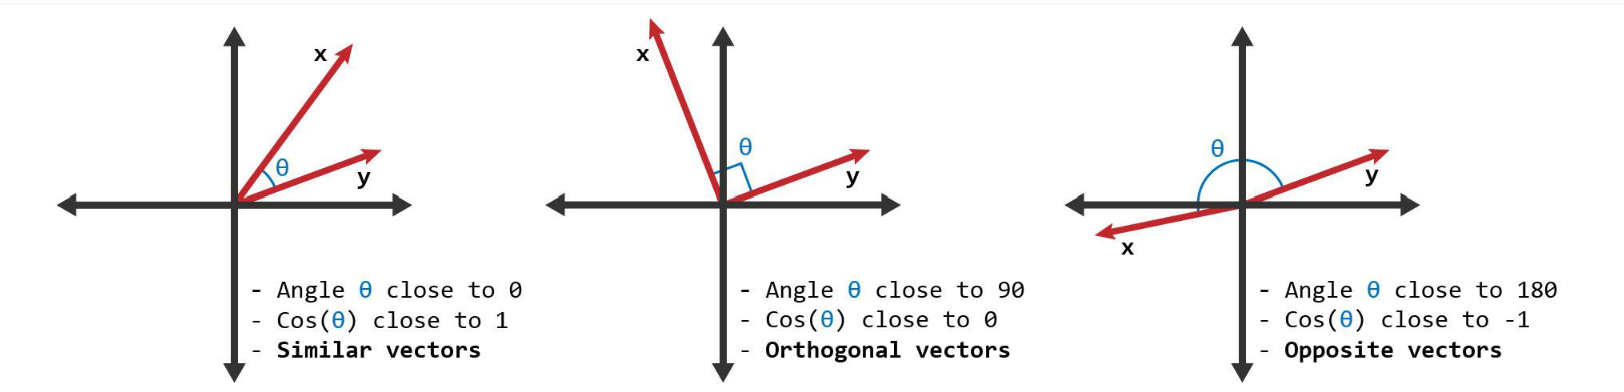

More about cosine similarity: https://www-sciencedirect-com.myaccess.library.utoronto.ca/topics/computer-science/cosine-similarity

https://www.learndatasci.com/glossary/cosine-similarity/

In [5]:
from sentence_transformers import SentenceTransformer, util
from sklearn.neighbors import NearestNeighbors
import pandas as pd

In [6]:
#Edited based on this source code: https://medium.com/@lvdeep9/fuzzy-data-matching-with-gpt-based-embeddings-and-nearest-neighbors-e89ed8800d68
#Swap out the encoder with a SBERT encoder instead of the OpenAI ada encoder

def fuzzy_match_huggingface(source_df, target_df, column, threshold=0.80):
    
    matched_results = source_df[[column]].copy().rename(columns={column:"Source"})
    
    model = SentenceTransformer('shahrukhx01/paraphrase-mpnet-base-v2-fuzzy-matcher')

    nn = NearestNeighbors(n_neighbors=1, metric='cosine').fit(model.encode(target_df[column]))
    distances, indices = nn.kneighbors(model.encode(source_df[column]), return_distance=True)

    matched_results[column + '_matched_to'] = [target_df.loc[indices[i, 0], column] for i in range(source_df.shape[0])]
    matched_results[column + '_similarity'] = 1 - distances
    matched_results[column + '_is_good_match'] = ['good' if 1 - distances[i, 0] >= threshold else 'bad' for i in range(source_df.shape[0])]

    return matched_results

In [7]:
#Example - encoders resulting in a 5376 X 768 dimension matrix - that is number of rows X max dimension

model = SentenceTransformer('shahrukhx01/paraphrase-mpnet-base-v2-fuzzy-matcher')
model.encode(data_211_2021['Name']).shape 

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/595 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/home/ja/miniconda3/envs/map/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(6405, 768)

### Matching 211 data to the filtered CRA dataset (2021)

The 211 data contains 4,222 rows whereas the filtered CRA data contains 1,170 rows. This iteration matches the larger dataset to the smaller one.

Matching the larger 211 dataset to the CRA dataset, returning only those rows that appear in both datasets.

That way, we can further filter out organizations by CRA categories

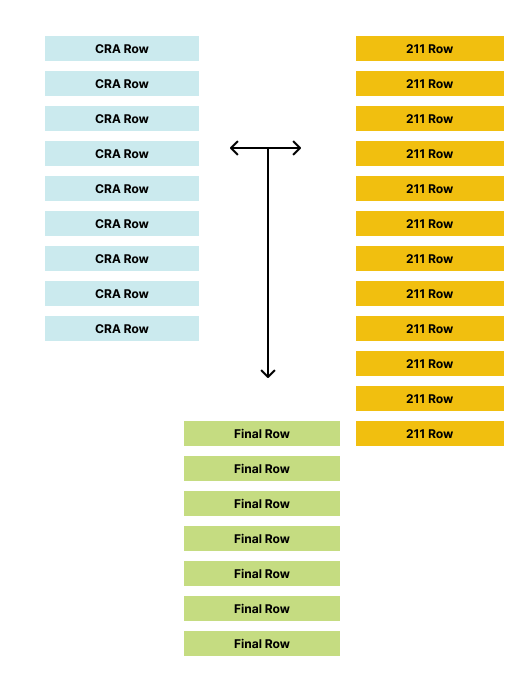

In [12]:
#Matching CRA dataset to 211 with a simiarlity threshold of 0.8
CRAto211 = fuzzy_match_huggingface(data_211_2021, selected_2021, "Name" ,0.80)
CRAto211.to_csv("test-match.csv")

/home/ja/miniconda3/envs/map/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
#Extracting matches that met the threshold of 0.8
# pd.set_option('display.max_rows', 500)
good_match = CRAto211[CRAto211["Name_is_good_match"]=="good"].reset_index(drop=True)
good_match = good_match.drop_duplicates(subset=["Source"]).reset_index(drop=True)
good_match

,Source,Name_matched_to,Name_similarity,Name_is_good_match
0,Canadian Baptists of Ontario and Quebec,Canadian Baptists of Ontario and Quebec,1.000000,good
1,Saint Elizabeth Rehab Health,Saint Elizabeth Health Services,0.826697,good
2,Eye Bank of Canada,THE EYE FOUNDATION OF CANADA,0.865426,good
3,World Vision Canada,WORLD VISION CANADA-VISION MONDIALE CANADA,0.845446,good
4,Pentecostal Assemblies of Canada,THE PENTECOSTAL ASSEMBLIES OF CANADA/LES ASSEM...,0.914107,good
...,...,...,...,...
573,CHATS - Community and Home Assistance to Seniors,CHATS-COMMUNITY & HOME ASSISTANCE TO SENIORS,0.997228,good
574,East York Meals on Wheels,EAST YORK MEALS ON WHEELS,1.000000,good
575,Parkdale Queen West Community Health Centre,WEST PARK HEALTHCARE CENTRE FOUNDATION,0.802684,good
576,Poverello Charities Ontario,POVERELLO CHARITIES ONTARIO,1.000000,good


In [135]:
# max_similarity_indices = good_match.groupby('Name_matched_to')['Name_similarity'].idxmax()
# good_match = good_match.loc[max_similarity_indices]
# good_match

,Source,Name_matched_to,Name_similarity,Name_is_good_match
466,Abbeyfield House of Toronto,ABBEYFIELD HOUSES SOCIETY OF TORONTO,0.898277,good
198,Aboriginal Legal Services,ABORIGINAL LEGAL SERVICES INC.,0.955145,good
243,Abrigo Centre,ABRIGO CENTRE,1.000000,good
135,Access for Parents and Children in Ontario,ACCESS FOR PARENTS AND CHILDREN IN ONTARIO,1.000000,good
377,Achev,ACHEV,1.000000,good
...,...,...,...,...
192,Youthdale Treatment Centres,YOUTHDALE TREATMENT CENTRES,1.000000,good
98,YouthLink,YOUTHLINK,1.000000,good
341,"York Hills Centre for Children, Youth and Fami...","York Hills Centre for Children, Youth and Fami...",1.000000,good
366,York Region Centre for Community Safety,York Region Centre for Community Safety,1.000000,good


**Incorrect Matches**

In [17]:
bad_match = CRAto211[CRAto211["Name_is_good_match"]=="bad"].reset_index(drop=True)
bad_match.to_csv("FuzzyMatchResults/bad_matches_2021.csv")

### Joining the matched results to the selected CRA dataset (2021) to count the 211 rows by CRA categories

This part captures the count of good matches between the 211 data and the previously selected CRA categories

In [197]:
#Joining the good matches from 211 to CRA 
good_match_2021_join = good_match.join(selected_2021.set_index("Name"), on="Name_matched_to", how="left",
                                            validate="m:1")

In [201]:
good_match_2021_join

,Source,Name_matched_to,Name_similarity,Name_is_good_match,BN,Category,Sub Category,Designation,Legal Name,Address Line 1,Address Line 2,City,Province,Postal Code,Country,Full_Address,Cat-Sub,4050,4155,4850
0,Canadian Baptists of Ontario and Quebec,Canadian Baptists of Ontario and Quebec,1.000000,good,118799071RR0001,30,4,C,CANADIAN BAPTISTS OF ONTARIO AND QUEBEC,5 INTERNATIONAL BLVD,NaN,ETOBICOKE,ON,M9W6H3,CA,"5 INTERNATIONAL BLVD,ETOBICOKE,ON","30, 4",NaN,6684115.0,287463.0
1,Saint Elizabeth Rehab Health,Saint Elizabeth Health Services,0.826697,good,831977251RR0001,150,5,C,SAINT ELIZABETH HEALTH SERVICES,90 ALL STATE PARKWAY,SUITE 300,MARKHAM,ON,L3R6H3,CA,"90 ALL STATE PARKWAY,MARKHAM,ON","150, 5",NaN,NaN,715572.0
2,Eye Bank of Canada,THE EYE FOUNDATION OF CANADA,0.865426,good,891355273RR0001,1,99,C,THE EYE FOUNDATION OF CANADA,316-2115 FINCH AVENUE WEST,NaN,DOWNSVIEW,ON,M3N2V6,CA,"316-2115 FINCH AVENUE WEST,DOWNSVIEW,ON","1, 99",N,NaN,NaN
3,World Vision Canada,WORLD VISION CANADA-VISION MONDIALE CANADA,0.845446,good,119304855RR0001,1,13,C,WORLD VISION CANADA-VISION MONDIALE CANADA,1 WORLD DR,NaN,MISSISSAUGA,ON,L5T2Y4,CA,"1 WORLD DR,MISSISSAUGA,ON","1, 13",NaN,19690821.0,886653.0
4,Pentecostal Assemblies of Canada,THE PENTECOSTAL ASSEMBLIES OF CANADA/LES ASSEM...,0.914107,good,107833295RR0374,30,11,C,THE PENTECOSTAL ASSEMBLIES OF CANADA/LES ASSEM...,2450 MILLTOWER COURT,NaN,MISSISSAUGA,ON,L5N5Z6,CA,"2450 MILLTOWER COURT,MISSISSAUGA,ON","30, 11",NaN,6341200.0,2747884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,CHATS - Community and Home Assistance to Seniors,CHATS-COMMUNITY & HOME ASSISTANCE TO SENIORS,0.997228,good,132090978RR0001,1,99,C,CHATS-COMMUNITY & HOME ASSISTANCE TO SENIORS,1-240 EDWARD STREET,NaN,AURORA,ON,L4G3S9,CA,"1-240 EDWARD STREET,AURORA,ON","1, 99",NaN,NaN,1043295.0
574,East York Meals on Wheels,EAST YORK MEALS ON WHEELS,1.000000,good,129139366RR0001,1,99,C,EAST YORK MEALS ON WHEELS,52 - 2 THORNCLIFFE PARK DR,NaN,EAST YORK,ON,M4H1H2,CA,"52 - 2 THORNCLIFFE PARK DR,EAST YORK,ON","1, 99",NaN,NaN,36684.0
575,Parkdale Queen West Community Health Centre,WEST PARK HEALTHCARE CENTRE FOUNDATION,0.802684,good,119295350RR0001,1,99,A,WEST PARK HEALTHCARE CENTRE FOUNDATION,82 BUTTONWOOD AVE,NaN,TORONTO,ON,M6M2J5,CA,"82 BUTTONWOOD AVE,TORONTO,ON","1, 99",NaN,NaN,NaN
576,Poverello Charities Ontario,POVERELLO CHARITIES ONTARIO,1.000000,good,129922902RR0001,70,99,C,POVERELLO CHARITIES ONTARIO,203 BERKELEY ST,NaN,TORONTO,ON,M5A2X3,CA,"203 BERKELEY ST,TORONTO,ON","70, 99",NaN,1482155.0,25221.0


In [203]:
def _removeisna(df):
    def _isna(row):
        if pd.isna(row["4050"]) and pd.isna(row["4155"]) and pd.isna(row["4850"]):
            return 0
        else:
            return 1

    # Apply the _isna function to each row and create a new column "Own_land"
    df["Check"] = df.apply(_isna, axis=1)
    
    df = df[df["Check"] == 1]
    
    return df.drop(columns=["Check"]).copy()

In [205]:
good_match_2021_join = _removeisna(good_match_2021_join)
good_match_2021_join

,Source,Name_matched_to,Name_similarity,Name_is_good_match,BN,Category,Sub Category,Designation,Legal Name,Address Line 1,Address Line 2,City,Province,Postal Code,Country,Full_Address,Cat-Sub,4050,4155,4850
0,Canadian Baptists of Ontario and Quebec,Canadian Baptists of Ontario and Quebec,1.000000,good,118799071RR0001,30,4,C,CANADIAN BAPTISTS OF ONTARIO AND QUEBEC,5 INTERNATIONAL BLVD,NaN,ETOBICOKE,ON,M9W6H3,CA,"5 INTERNATIONAL BLVD,ETOBICOKE,ON","30, 4",NaN,6684115.0,287463.0
1,Saint Elizabeth Rehab Health,Saint Elizabeth Health Services,0.826697,good,831977251RR0001,150,5,C,SAINT ELIZABETH HEALTH SERVICES,90 ALL STATE PARKWAY,SUITE 300,MARKHAM,ON,L3R6H3,CA,"90 ALL STATE PARKWAY,MARKHAM,ON","150, 5",NaN,NaN,715572.0
2,Eye Bank of Canada,THE EYE FOUNDATION OF CANADA,0.865426,good,891355273RR0001,1,99,C,THE EYE FOUNDATION OF CANADA,316-2115 FINCH AVENUE WEST,NaN,DOWNSVIEW,ON,M3N2V6,CA,"316-2115 FINCH AVENUE WEST,DOWNSVIEW,ON","1, 99",N,NaN,NaN
3,World Vision Canada,WORLD VISION CANADA-VISION MONDIALE CANADA,0.845446,good,119304855RR0001,1,13,C,WORLD VISION CANADA-VISION MONDIALE CANADA,1 WORLD DR,NaN,MISSISSAUGA,ON,L5T2Y4,CA,"1 WORLD DR,MISSISSAUGA,ON","1, 13",NaN,19690821.0,886653.0
4,Pentecostal Assemblies of Canada,THE PENTECOSTAL ASSEMBLIES OF CANADA/LES ASSEM...,0.914107,good,107833295RR0374,30,11,C,THE PENTECOSTAL ASSEMBLIES OF CANADA/LES ASSEM...,2450 MILLTOWER COURT,NaN,MISSISSAUGA,ON,L5N5Z6,CA,"2450 MILLTOWER COURT,MISSISSAUGA,ON","30, 11",NaN,6341200.0,2747884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,Vaughan Medical Centre,Vaughan Community Health Centre Corporation,0.828376,good,844664565RR0001,100,2,C,Vaughan Community Health Centre Corporation,9401 JANE STREET,SUITE 206,VAUGHAN,ON,L6A4H7,CA,"9401 JANE STREET,VAUGHAN,ON","100, 2",NaN,NaN,671170.0
573,CHATS - Community and Home Assistance to Seniors,CHATS-COMMUNITY & HOME ASSISTANCE TO SENIORS,0.997228,good,132090978RR0001,1,99,C,CHATS-COMMUNITY & HOME ASSISTANCE TO SENIORS,1-240 EDWARD STREET,NaN,AURORA,ON,L4G3S9,CA,"1-240 EDWARD STREET,AURORA,ON","1, 99",NaN,NaN,1043295.0
574,East York Meals on Wheels,EAST YORK MEALS ON WHEELS,1.000000,good,129139366RR0001,1,99,C,EAST YORK MEALS ON WHEELS,52 - 2 THORNCLIFFE PARK DR,NaN,EAST YORK,ON,M4H1H2,CA,"52 - 2 THORNCLIFFE PARK DR,EAST YORK,ON","1, 99",NaN,NaN,36684.0
576,Poverello Charities Ontario,POVERELLO CHARITIES ONTARIO,1.000000,good,129922902RR0001,70,99,C,POVERELLO CHARITIES ONTARIO,203 BERKELEY ST,NaN,TORONTO,ON,M5A2X3,CA,"203 BERKELEY ST,TORONTO,ON","70, 99",NaN,1482155.0,25221.0


In [207]:
#Check how many 211 organizations have multiple locations under the same organization name
location_count_211 = data_211_2021.drop(columns=["211_City", "211_County", "211_Province", "Latitude", "Longitude"])
location_count_211 = location_count_211.groupby(by=["Name"]).size().reset_index().rename(columns={0:"Count"})
location_count_211

,Name,Count
0,105 Gibson Centre,1
1,2-Spirited People of the 1st Nations,1
2,360 Kids,7
3,519 Community Centre,3
4,5N2Kitchens,1
...,...,...
3566,recycleMYelectronics.ca,1
3567,respiteservices.com,1
3568,teenlegalhelpline.org,1
3569,ventureLAB,1


In [209]:
#Join the 211 location count to the cra-211 good match dataset
good_match_2021_join = good_match_2021_join.join(location_count_211.set_index("Name"), on="Source", how="left")

In [211]:
def own_land (row): 
    
    if row["4050"] == "Y" or row["4155"] > 0: 
        return 1 
    else:
        return 0

In [213]:
good_match_2021_join["Own_land"] = good_match_2021_join.apply(own_land, axis=1)

In [215]:
#Join the 211 data
final_2021 = data_211_2021.join(good_match_2021_join.set_index("Source"), on="Name", how="inner", lsuffix="211").reset_index(drop=True)
final_2021

,PublicName,Name,211_Address1,211_Address2,211_City,211_County,211_Province,211_PostalCode,Latitude,Longitude,...,Province,Postal Code,Country,Full_Address,Cat-Sub,4050,4155,4850,Count,Own_land
0,Canadian Baptists of Ontario and Quebec - Cana...,Canadian Baptists of Ontario and Quebec,Canadian Baptists of Ontario and Quebec; 5 Int...,Ste 100,Toronto,Toronto,ON,M9W 6H3,43.677053,-79.590212,...,ON,M9W6H3,CA,"5 INTERNATIONAL BLVD,ETOBICOKE,ON","30, 4",NaN,6684115.0,287463.0,1,1
1,Saint Elizabeth Rehab Health - Saint Elizabeth...,Saint Elizabeth Rehab Health,10830 Bayview Ave,Suite 201,Richmond Hill,York,ON,L4S 1L7,43.895252,-79.420620,...,ON,L3R6H3,CA,"90 ALL STATE PARKWAY,MARKHAM,ON","150, 5",NaN,NaN,715572.0,1,0
2,Eye Bank of Canada - Eye Bank of Canada,Eye Bank of Canada,340 College St,Ste B100,Toronto,Toronto,ON,M5T 3A9,43.717950,-79.377705,...,ON,M3N2V6,CA,"316-2115 FINCH AVENUE WEST,DOWNSVIEW,ON","1, 99",N,NaN,NaN,1,0
3,World Vision Canada - World Vision Canada,World Vision Canada,1 World Dr,NaN,Mississauga,Peel,ON,L5T 2Y4,43.634042,-79.688440,...,ON,L5T2Y4,CA,"1 WORLD DR,MISSISSAUGA,ON","1, 13",NaN,19690821.0,886653.0,1,1
4,Pentecostal Assemblies of Canada - Pentecostal...,Pentecostal Assemblies of Canada,2450 Milltower Crt,NaN,Mississauga,Peel,ON,L5N 5Z6,43.357372,-79.796831,...,ON,L5N5Z6,CA,"2450 MILLTOWER COURT,MISSISSAUGA,ON","30, 11",NaN,6341200.0,2747884.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405,East York Meals on Wheels - Congregate Dining,East York Meals on Wheels,2 Thorncliffe Park Dr,Unit 52,Toronto,Toronto,ON,M4H 1H2,43.706500,-79.351600,...,ON,M4H1H2,CA,"52 - 2 THORNCLIFFE PARK DR,EAST YORK,ON","1, 99",NaN,NaN,36684.0,5,0
1406,East York Meals on Wheels - Security Check,East York Meals on Wheels,2 Thorncliffe Park Dr,Unit 52,Toronto,Toronto,ON,M4H 1H2,43.706500,-79.351600,...,ON,M4H1H2,CA,"52 - 2 THORNCLIFFE PARK DR,EAST YORK,ON","1, 99",NaN,NaN,36684.0,5,0
1407,East York Meals on Wheels - East York Meals on...,East York Meals on Wheels,2 Thorncliffe Park Dr,Unit 52,Toronto,Toronto,ON,M4H 1H2,43.706500,-79.351600,...,ON,M4H1H2,CA,"52 - 2 THORNCLIFFE PARK DR,EAST YORK,ON","1, 99",NaN,NaN,36684.0,5,0
1408,Poverello Charities Ontario - Poverello Charit...,Poverello Charities Ontario,203 Berkeley St,NaN,Toronto,Toronto,ON,M5A 2X3,43.657100,-79.366200,...,ON,M5A2X3,CA,"203 BERKELEY ST,TORONTO,ON","70, 99",NaN,1482155.0,25221.0,1,1


In [217]:
final_2021 = final_2021.rename(columns={
    'Name':"211 Parent Agency Name",
    'Name_matched_to':"CRA Name",
    'Name_similarity':"Match Score", 
    'Name_is_good_match': "Match Level", 
    'Category':"CRA Category",
    'Sub Category': "CRA Subcategory",
    'Full_Address':"CRA Address",
    'Cat-Sub':"Category-SubCategory Match Code",
    '4050':"secD_LandOwnship",
    '4155':"Land Value",
    '4850':"Occupancy Costs",
    'Count':"Total Location Count",
    'Own_land':"All Land Ownership",
})

In [269]:
def own_land (row): 
    
    if row["Total Location Count"] == 1 and row["All Land Ownership"] ==1: 
        return "Own" 

    elif row["All Land Ownership"] ==0:
        return "Rent" 
        
    else:
        return "TBC"

In [271]:
final_2021["Tenure"] = final_2021.apply(own_land, axis=1)

In [273]:
final_2021

,PublicName,211 Parent Agency Name,211_Address1,211_Address2,211_City,211_County,211_Province,211_PostalCode,Latitude,Longitude,...,Postal Code,Country,CRA Address,Category-SubCategory Match Code,secD_LandOwnship,Land Value,Occupancy Costs,Total Location Count,All Land Ownership,Tenure
0,Canadian Baptists of Ontario and Quebec - Cana...,Canadian Baptists of Ontario and Quebec,Canadian Baptists of Ontario and Quebec; 5 Int...,Ste 100,Toronto,Toronto,ON,M9W 6H3,43.677053,-79.590212,...,M9W6H3,CA,"5 INTERNATIONAL BLVD,ETOBICOKE,ON","30, 4",NaN,6684115.0,287463.0,1,1,Own
1,Saint Elizabeth Rehab Health - Saint Elizabeth...,Saint Elizabeth Rehab Health,10830 Bayview Ave,Suite 201,Richmond Hill,York,ON,L4S 1L7,43.895252,-79.420620,...,L3R6H3,CA,"90 ALL STATE PARKWAY,MARKHAM,ON","150, 5",NaN,NaN,715572.0,1,0,Rent
2,Eye Bank of Canada - Eye Bank of Canada,Eye Bank of Canada,340 College St,Ste B100,Toronto,Toronto,ON,M5T 3A9,43.717950,-79.377705,...,M3N2V6,CA,"316-2115 FINCH AVENUE WEST,DOWNSVIEW,ON","1, 99",N,NaN,NaN,1,0,Rent
3,World Vision Canada - World Vision Canada,World Vision Canada,1 World Dr,NaN,Mississauga,Peel,ON,L5T 2Y4,43.634042,-79.688440,...,L5T2Y4,CA,"1 WORLD DR,MISSISSAUGA,ON","1, 13",NaN,19690821.0,886653.0,1,1,Own
4,Pentecostal Assemblies of Canada - Pentecostal...,Pentecostal Assemblies of Canada,2450 Milltower Crt,NaN,Mississauga,Peel,ON,L5N 5Z6,43.357372,-79.796831,...,L5N5Z6,CA,"2450 MILLTOWER COURT,MISSISSAUGA,ON","30, 11",NaN,6341200.0,2747884.0,1,1,Own
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405,East York Meals on Wheels - Congregate Dining,East York Meals on Wheels,2 Thorncliffe Park Dr,Unit 52,Toronto,Toronto,ON,M4H 1H2,43.706500,-79.351600,...,M4H1H2,CA,"52 - 2 THORNCLIFFE PARK DR,EAST YORK,ON","1, 99",NaN,NaN,36684.0,5,0,Rent
1406,East York Meals on Wheels - Security Check,East York Meals on Wheels,2 Thorncliffe Park Dr,Unit 52,Toronto,Toronto,ON,M4H 1H2,43.706500,-79.351600,...,M4H1H2,CA,"52 - 2 THORNCLIFFE PARK DR,EAST YORK,ON","1, 99",NaN,NaN,36684.0,5,0,Rent
1407,East York Meals on Wheels - East York Meals on...,East York Meals on Wheels,2 Thorncliffe Park Dr,Unit 52,Toronto,Toronto,ON,M4H 1H2,43.706500,-79.351600,...,M4H1H2,CA,"52 - 2 THORNCLIFFE PARK DR,EAST YORK,ON","1, 99",NaN,NaN,36684.0,5,0,Rent
1408,Poverello Charities Ontario - Poverello Charit...,Poverello Charities Ontario,203 Berkeley St,NaN,Toronto,Toronto,ON,M5A 2X3,43.657100,-79.366200,...,M5A2X3,CA,"203 BERKELEY ST,TORONTO,ON","70, 99",NaN,1482155.0,25221.0,1,1,Own


In [275]:
final_2021.to_csv("GIS Analysis/cra-211-match/final_2021_v3.csv")

In [277]:
final_2021.to_excel("GIS Analysis/cra-211-match/final_2021_v3.xlsx", index=False, sheet_name='2021')

### Filter the list of Organizations with more than 1 Location (2021)

In [81]:
#Organizations that own land and have multiple locations
multiple_location_2021 = final_2021[(final_2021["All Land Ownership"]==1) & (final_2021["Total Location Count"]>1)]
multiple_location_2021

,211 Name,211 City,Region,211 Province,Latitude,Longitude,CRA Name,Match Score,Match Level,BN,CRA Category,CRA Subcategory,Designation,Legal Name,Address Line 1,Address Line 2,City,Province,Postal Code,Country,CRA Address,Category-SubCategory Match Code,secD_LandOwnship,Land Value,Occupancy Costs,Total Location Count,All Land Ownership
23,Ontario Addiction Treatment Centres,Markham,York,ON,43.841437,-79.385447,ADDICTION SERVICES CENTRAL ONTARIO,0.894545,good,130043276RR0001,100,1,C,ADDICTION SERVICES CENTRAL ONTARIO,"14785 YONGE STREET, SUITE 210",NaN,AURORA,ON,L4G1N1,CA,"14785 YONGE STREET, SUITE 210,AURORA,ON","100, 1",NaN,119031.0,702732.0,3,1
27,Mon Sheong Foundation,Toronto,Toronto,ON,43.813088,-79.299988,MON SHEONG FOUNDATION,1.000000,good,119044618RR0001,1,99,C,MON SHEONG FOUNDATION,36 D'ARCY STREET,NaN,TORONTO,ON,M5T1J7,CA,"36 D'ARCY STREET,TORONTO,ON","1, 99",NaN,157325805.0,14452226.0,3,1
29,North Yorkers for Disabled Persons,Toronto,Toronto,ON,43.767867,-79.388746,"NORTH YORKERS FOR DISABLED PERSONS, INC",0.972461,good,120565239RR0001,1,99,C,"NORTH YORKERS FOR DISABLED PERSONS, INC.",2880 BAYVIEW AVE,NaN,NORTH YORK,ON,M2N5K3,CA,"2880 BAYVIEW AVE,NORTH YORK,ON","1, 99",NaN,554075.0,93934.0,2,1
30,North Yorkers for Disabled Persons,Toronto,Toronto,ON,43.767472,-79.390066,"NORTH YORKERS FOR DISABLED PERSONS, INC",0.972461,good,120565239RR0001,1,99,C,"NORTH YORKERS FOR DISABLED PERSONS, INC.",2880 BAYVIEW AVE,NaN,NORTH YORK,ON,M2N5K3,CA,"2880 BAYVIEW AVE,NORTH YORK,ON","1, 99",NaN,554075.0,93934.0,2,1
33,Mon Sheong Foundation,Richmond Hill,York,ON,43.901336,-79.443199,MON SHEONG FOUNDATION,1.000000,good,119044618RR0001,1,99,C,MON SHEONG FOUNDATION,36 D'ARCY STREET,NaN,TORONTO,ON,M5T1J7,CA,"36 D'ARCY STREET,TORONTO,ON","1, 99",NaN,157325805.0,14452226.0,3,1
45,Toronto Finnish Canadian Seniors Centre,Toronto,Toronto,ON,43.713221,-79.365960,TORONTO FINNISH-CANADIAN SENIORS CENTRE,0.991519,good,119266534RR0001,1,99,C,TORONTO FINNISH-CANADIAN SENIORS CENTRE,795 EGLINTON AVE.E.,NaN,TORONTO,ON,M4G4E4,CA,"795 EGLINTON AVE.E.,TORONTO,ON","1, 99",NaN,20593724.0,1202980.0,2,1
46,Toronto Finnish Canadian Seniors Centre,Toronto,Toronto,ON,43.713100,-79.366100,TORONTO FINNISH-CANADIAN SENIORS CENTRE,0.991519,good,119266534RR0001,1,99,C,TORONTO FINNISH-CANADIAN SENIORS CENTRE,795 EGLINTON AVE.E.,NaN,TORONTO,ON,M4G4E4,CA,"795 EGLINTON AVE.E.,TORONTO,ON","1, 99",NaN,20593724.0,1202980.0,2,1
52,St. James the Apostle Anglican Church,East Gwillimbury,York,ON,44.097171,-79.440765,ST. JAMES UNITED CHURCH,0.855299,good,108021700RR0001,30,15,C,ST. JAMES UNITED CHURCH,400 BURNHAMTHORPE ROAD,NaN,ETOBICOKE,ON,M9B2A8,CA,"400 BURNHAMTHORPE ROAD,ETOBICOKE,ON","30, 15",NaN,732670.0,66528.0,2,1
54,St. James the Apostle Anglican Church,East Gwillimbury,York,ON,44.097171,-79.440765,THE CATHEDRAL CHURCH OF ST. JAMES,0.832455,good,119176923RR0001,30,2,C,THE CATHEDRAL CHURCH OF ST. JAMES,65 CHURCH ST,NaN,TORONTO,ON,M5C2E9,CA,"65 CHURCH ST,TORONTO,ON","30, 2",NaN,22496168.0,323600.0,2,1
55,St. James the Apostle Anglican Church,East Gwillimbury,York,ON,44.097171,-79.440765,ST JAMES PRESBYTERIAN CHURCH,0.855113,good,133286203RR0001,30,12,C,ST JAMES PRESBYTERIAN CHURCH,6432 MAIN ST,NaN,STOUFFVILLE,ON,L4A1G3,CA,"6432 MAIN ST,STOUFFVILLE,ON","30, 12",NaN,2147516.0,15875.0,2,1


### Count of Matched Results by CRA Categories (2021)

In [83]:
final_2021.columns

Index(['211 Name', '211 City', 'Region', '211 Province', 'Latitude',
       'Longitude', 'CRA Name', 'Match Score', 'Match Level', 'BN',
       'CRA Category', 'CRA Subcategory', 'Designation', 'Legal Name',
       'Address Line 1', 'Address Line 2', 'City', 'Province', 'Postal Code',
       'Country', 'CRA Address', 'Category-SubCategory Match Code',
       'secD_LandOwnship', 'Land Value', 'Occupancy Costs',
       'Total Location Count', 'All Land Ownership'],
      dtype='object')

In [87]:
cat_count = final_2021.groupby(by=["CRA Category", "CRA Subcategory"]).size().reset_index().rename(columns=
                                                                                                     {0:"Count"})
cat_count["Match_Code"] = cat_count["CRA Category"].astype(str) + ", " + cat_count["CRA Subcategory"].astype(str)

In [91]:
org = pd.read_excel("2021_ListOfCharities/Organization_Type.xlsx", sheet_name="Organization-Type")
org["MatchCode"] = org["Category Code"].astype(str) + ", " + org["Sub-Category Code"].astype(str)

C:\Users\teres\anaconda3\envs\ml\lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [93]:
cat_count = cat_count.join(org.set_index("MatchCode"), on="Match_Code", how="left")

In [95]:
#Count of categories included in the selected 2021 CRA dataset

cat_count = cat_count[['Match_Code', 'Type','Category Code', 'Category Description',
                       'Sub-Category Code','Sub-Category Description','Count']]

cat_count

,Match_Code,Type,Category Code,Category Description,Sub-Category Code,Sub-Category Description,Count
0,"1, 4",Relief of Poverty,1,Organizations Relieving Poverty,4,Operating a food bank,22
1,"1, 6",Relief of Poverty,1,Organizations Relieving Poverty,6,Operating a shelter,1
2,"1, 7",Relief of Poverty,1,Organizations Relieving Poverty,7,Orphanage,1
3,"1, 9",Relief of Poverty,1,Organizations Relieving Poverty,9,Providing low-cost housing,14
4,"1, 13",Relief of Poverty,1,Organizations Relieving Poverty,13,Providing material assistance (clothing / comp...,23
5,"1, 15",Relief of Poverty,1,Organizations Relieving Poverty,15,Refugee (support and settlement assistance),27
6,"1, 99",Relief of Poverty,1,Organizations Relieving Poverty,99,Other,1155
7,"30, 1",Advancement of Religion,30,Christianity,1,Adventist,16
8,"30, 2",Advancement of Religion,30,Christianity,2,Anglican,44
9,"30, 4",Advancement of Religion,30,Christianity,4,Baptist,26


# 2019

In [13]:
#Import 2021 211 data

data_211_2019 = pd.read_csv("211 Data/2019_211_PeelYorkTO.csv", encoding='latin-1')
data_211_2019 = data_211_2019.rename(columns={"ParentAgency":"Name",
                                             "PublicName":"211_PublicName",
                                              "PhysicalAddress1":"211_Address1",
                                              "PhysicalAddress2":"211_Address2",
                                              "PhysicalCity":"211_City",
                                              "PhysicalCounty":"211_County",
                                              "PhysicalStateProvince":"211_Province",
                                             "PhysicalPostalCode":"211_PostalCode",
                                             })
data_211_2019 = data_211_2019.drop_duplicates(subset=["211_PublicName", "Latitude", "Longitude"]).reset_index(drop=True)
data_211_2019

,211_PublicName,Name,211_Address1,211_Address2,211_City,211_County,211_Province,211_PostalCode,Latitude,Longitude
0,105 Gibson Centre,105 Gibson Centre,105 Gibson Dr,NaN,Markham,York,ON,L3R 3K7,43.9023,-79.2457
1,2-Spirited People of the 1st Nations,2-Spirited People of the 1st Nations,145 Front St E,Suite 105,Toronto,Toronto,ON,M5A 1E3,43.6574,-79.4328
2,303 Pediatrics,303 Pediatrics,115 Humber College Blvd,Suite 722,Toronto,Toronto,ON,M9V 4B8,43.6574,-79.5814
3,360 Kids,360 Kids,80F Centurian Dr,Suite 200,Markham,York,ON,L3R 8C1,43.9023,-79.2457
4,404 Veterinary Emergency and Referral Hospital,404 Veterinary Emergency and Referral Hospital,510 Harry Walker Pkwy S,NaN,Newmarket,York,ON,L3Y 0B3,44.0577,-79.4707
...,...,...,...,...,...,...,...,...,...,...
3607,Toronto Workers Health and Safety Legal Clinic,Workers Health and Safety Legal Clinic,"180, rue Dundas Ouest",bureau 2000,Toronto,Toronto,ON,M5G 1Z8,43.6574,-79.4328
3608,Commission de la sécurité professionnelle et d...,Workplace Safety and Insurance Board,"Simcoe Place; 200, rue Front Ouest",NaN,Toronto,Toronto,ON,M5V 3J1,43.6574,-79.4328
3609,Inactif YMCA of Greater Toronto,YMCA of Greater Toronto,Administrative office; 2200 Yonge St,Suite 300,Toronto,Toronto,ON,M4S 2C6,43.6574,-79.4328
3610,Inactif York (Region of),York (Region of),17250 Yonge St,NaN,Newmarket,York,ON,L3Y 6Z1,44.0577,-79.4707


In [15]:
#Import selected CRA 2021 data based on previously discussed categories
selected_2019 = pd.read_csv("GIS Analysis/selected_cra/cra_selected_2019.csv")
selected_2019 = selected_2019.drop(columns=["Unnamed: 0"]).rename(columns={"Account Name":"Name"})
selected_2019["Name"]=selected_2019["Name"].str.split(pat=" - ", n=1).str[0]
selected_2019 = selected_2019.drop_duplicates(subset=["Name"]).reset_index(drop=True)
selected_2019

,BN,Category,Sub Category,Designation,Legal Name,Name,Address Line 1,Address Line 2,City,Province,Postal Code,Country,Full_Address,Cat-Sub,4050,4155,4850
0,825253719RR0001,30,99,C,KABIR ASSOCIATION OF TORONTO INC.,Kabir Association of Toronto Inc.,"3646 LAWRENCE AVENUE EAST,",NaN,SCARBOROUGH,ON,M1G1P6,CA,"3646 LAWRENCE AVENUE EAST,,SCARBOROUGH,ON","30, 99",NaN,NaN,NaN
1,835510041RR0001,1,99,C,Feet Forward,Feet Forward Organization,33 FERMANAGH AVE,NaN,TORONTO,ON,M6R1M1,CA,"33 FERMANAGH AVE,TORONTO,ON","1, 99",N,NaN,NaN
2,828678490RR0001,30,99,C,Christ Agape Fellowship International,Christ Agape Fellowship International,112 NEAMES CRESCENT,NaN,TORONTO,ON,M3L1K9,CA,"112 NEAMES CRESCENT,TORONTO,ON","30, 99",N,NaN,NaN
3,728822321RR0001,60,2,C,RIWOTSEGYA THROMA BUDDHIST INSTITUTE,Riwotsegya Throma Buddhist Institute,133 EILEEN AVE.,NaN,TORONTO,ON,M6N1W3,CA,"133 EILEEN AVE.,TORONTO,ON","60, 2",Y,NaN,NaN
4,863311866RR0001,1,7,C,ALAMELU CHILDREN'S HOMES (CANADA),ALAMELU CHILDREN'S HOMES (CANADA),205 - 2511 BLOOR ST W,NaN,TORONTO,ON,M6S5A6,CA,"205 - 2511 BLOOR ST W,TORONTO,ON","1, 7",N,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5823,888541042RR0001,70,99,B,T N T CHRISTIAN TRUST FUND,T N T CHRISTIAN TRUST FUND,2 WOODSEND CRES,NaN,AURORA,ON,L4G6W6,CA,"2 WOODSEND CRES,AURORA,ON","70, 99",NaN,NaN,NaN
5824,828676601RR0001,30,99,B,VAUGHAN SARANG CHURCH,Vaughan Sarang Church,1901 - 350 WEBB DR,NaN,MISSISSAUGA,ON,L5B3W4,CA,"1901 - 350 WEBB DR,MISSISSAUGA,ON","30, 99",N,NaN,NaN
5825,814872636RR0001,1,99,C,DRESS FOR SUCCESS ORILLIA AND BARRIE,Dress For Success Orillia and Barrie,79 - 320 BAYFIELD ST,NaN,SPRINGWATER,ON,L4M3C1,CA,"79 - 320 BAYFIELD ST,SPRINGWATER,ON","1, 99",NaN,0.0,33278.0
5826,718224694RR0001,160,17,C,Canada Forward Foundation,Canada Forward Foundation,262 GRAND VELLORE CRES,NaN,WOODBRIDGE,ON,L4H0N7,CA,"262 GRAND VELLORE CRES,WOODBRIDGE,ON","160, 17",N,NaN,NaN


In [23]:
#Matching 211 dataset to the CRA dataset with a simiarlity threshold of 0.8
CRAto211_2019 = fuzzy_match_huggingface(data_211_2019, selected_2019, "Name" ,0.80)
CRAto211_2019

C:\Users\teres\anaconda3\envs\ml\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


,Source,Name_matched_to,Name_similarity,Name_is_good_match
0,105 Gibson Centre,BARRIE VICTORY CENTRE,0.560458,bad
1,2-Spirited People of the 1st Nations,Native Peoples' Mission,0.645058,bad
2,303 Pediatrics,KALEIDOSCOPE PRESCHOOL RESOURCE CENTRE,0.475289,bad
3,360 Kids,360Kids Support Services,0.656815,bad
4,404 Veterinary Emergency and Referral Hospital,HUMANE MEDICINE INC.,0.485682,bad
...,...,...,...,...
3607,Workers Health and Safety Legal Clinic,Workplace Health Without Borders,0.617741,bad
3608,Workplace Safety and Insurance Board,Workplace Health Without Borders,0.610874,bad
3609,YMCA of Greater Toronto,YMCA OF GREATER TORONTO,1.000000,good
3610,York (Region of),The Food Bank of York Region,0.663516,bad


In [33]:
#Extracting matches that met the threshold of 0.8
# pd.set_option('display.max_rows', 500)
good_match_2019 = CRAto211_2019[CRAto211_2019["Name_is_good_match"]=="good"].reset_index(drop=True)
good_match_2019 = good_match_2019.drop_duplicates(subset=["Source"]).reset_index(drop=True)
good_match_2019

,Source,Name_matched_to,Name_similarity,Name_is_good_match
0,519 Community Centre,COMMUNITY CENTRE 55,0.842917,good
1,Abbeyfield House of Toronto,ABBEYFIELD HOUSES SOCIETY OF TORONTO,0.898277,good
2,Aboriginal Legal Services,ABORIGINAL LEGAL SERVICES INC.,0.955145,good
3,Abrigo Centre,ABRIGO CENTRE,1.000000,good
4,Access for Parents and Children in Ontario,ACCESS FOR PARENTS AND CHILDREN IN ONTARIO,1.000000,good
...,...,...,...,...
578,Yorktown Family Services,Yorktown Family Services,1.000000,good
579,Youth Assisting Youth,YOUTH ASSISTING YOUTH,1.000000,good
580,Youth Employment Services YES,YOUTH EMPLOYMENT SERVICES YES,1.000000,good
581,Youthdale Treatment Centres,YOUTHDALE TREATMENT CENTRES,1.000000,good


In [15]:
# max_similarity_indices = good_match_2019.groupby('Name_matched_to')['Name_similarity'].idxmax()
# good_match_2019 = good_match_2019.loc[max_similarity_indices].reset_index(drop=True)
# good_match_2019

,Source,Name_matched_to,Name_similarity,Name_is_good_match
0,Abbeyfield House of Toronto,ABBEYFIELD HOUSES SOCIETY OF TORONTO,0.898277,good
1,Aboriginal Legal Services,ABORIGINAL LEGAL SERVICES INC.,0.955145,good
2,Abrigo Centre,ABRIGO CENTRE,1.000000,good
3,Access for Parents and Children in Ontario,ACCESS FOR PARENTS AND CHILDREN IN ONTARIO,1.000000,good
4,Across U-hub,ACROSS U-HUB,1.000000,good
...,...,...,...,...
499,Youth Employment Services YES,YOUTH EMPLOYMENT SERVICES YES,1.000000,good
500,Youthdale Treatment Centres,YOUTHDALE TREATMENT CENTRES,1.000000,good
501,YouthLink,YOUTHLINK,1.000000,good
502,"York Centre for Children, Youth and Families, ...","York Hills Centre for Children, Youth and Fami...",0.821950,good


In [17]:
bad_match_2019 = CRAto211_2019[CRAto211_2019["Name_is_good_match"]=="bad"].reset_index(drop=True)
bad_match_2019.to_csv("FuzzyMatchResults/bad_matches_2019.csv")

In [37]:
#Joining the good matches from 211 to CRA 
good_match_2019_join = good_match_2019.join(selected_2019.set_index("Name"), on="Name_matched_to", how="left",
                                            validate="m:1")

In [39]:
def _removeisna(df):
    def _isna(row):
        if pd.isna(row["4050"]) and pd.isna(row["4155"]) and pd.isna(row["4850"]):
            return 0
        else:
            return 1

    # Apply the _isna function to each row and create a new column "Own_land"
    df["Check"] = df.apply(_isna, axis=1)
    
    df = df[df["Check"] == 1]
    
    return df.drop(columns=["Check"]).copy()

In [41]:
good_match_2019_join = _removeisna(good_match_2019_join)
good_match_2019_join

,Source,Name_matched_to,Name_similarity,Name_is_good_match,BN,Category,Sub Category,Designation,Legal Name,Address Line 1,Address Line 2,City,Province,Postal Code,Country,Full_Address,Cat-Sub,4050,4155,4850
0,519 Community Centre,COMMUNITY CENTRE 55,0.842917,good,118870310RR0001,1,99,C,COMMUNITY CENTRE 55,97 MAIN STREET,NaN,TORONTO,ON,M4E2V6,CA,"97 MAIN STREET,TORONTO,ON","1, 99",NaN,NaN,94920.0
1,Abbeyfield House of Toronto,ABBEYFIELD HOUSES SOCIETY OF TORONTO,0.898277,good,124186115RR0001,1,99,C,ABBEYFIELD HOUSES SOCIETY OF TORONTO,38 LAKESIDE AVE,NaN,SCARBOROUGH,ON,M1N3C1,CA,"38 LAKESIDE AVE,SCARBOROUGH,ON","1, 99",NaN,1010464.0,48655.0
2,Aboriginal Legal Services,ABORIGINAL LEGAL SERVICES INC.,0.955145,good,129565040RR0001,160,9,C,ABORIGINAL LEGAL SERVICES INC.,500 - 211 YONGE ST,NaN,TORONTO,ON,M5B1M4,CA,"500 - 211 YONGE ST,TORONTO,ON","160, 9",NaN,NaN,349431.0
3,Abrigo Centre,ABRIGO CENTRE,1.000000,good,129515284RR0001,1,99,C,ABRIGO CENTRE,1645 DUFFERIN ST,NaN,TORONTO,ON,M6H3L9,CA,"1645 DUFFERIN ST,TORONTO,ON","1, 99",NaN,NaN,193723.0
4,Access for Parents and Children in Ontario,ACCESS FOR PARENTS AND CHILDREN IN ONTARIO,1.000000,good,118776848RR0001,1,99,C,ACCESS FOR PARENTS AND CHILDREN IN ONTARIO,100 SHEPPARD AVENUE EAST,SUITE 504,TORONTO,ON,M2N6N5,CA,"100 SHEPPARD AVENUE EAST,TORONTO,ON","1, 99",NaN,NaN,84798.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,Yorktown Family Services,Yorktown Family Services,1.000000,good,136729597RR0001,1,99,C,YORKTOWN FAMILY SERVICES,300 - 2010 EGLINTON AVE W,NaN,YORK,ON,M6E2K3,CA,"300 - 2010 EGLINTON AVE W,YORK,ON","1, 99",NaN,643890.0,412158.0
579,Youth Assisting Youth,YOUTH ASSISTING YOUTH,1.000000,good,119307478RR0001,1,99,C,YOUTH ASSISTING YOUTH,5734 YONGE STREET,SUITE 401,TORONTO,ON,M2M4E7,CA,"5734 YONGE STREET,TORONTO,ON","1, 99",NaN,NaN,128683.0
580,Youth Employment Services YES,YOUTH EMPLOYMENT SERVICES YES,1.000000,good,832756720RR0001,1,99,C,YOUTH EMPLOYMENT SERVICES YES,711-555 RICHMOND ST WEST,BOX 115,TORONTO,ON,M5V3B1,CA,"711-555 RICHMOND ST WEST,TORONTO,ON","1, 99",NaN,NaN,848824.0
581,Youthdale Treatment Centres,YOUTHDALE TREATMENT CENTRES,1.000000,good,108228156RR0001,100,2,C,YOUTHDALE TREATMENT CENTRES,227 VICTORIA ST,NaN,TORONTO,ON,M5B1T8,CA,"227 VICTORIA ST,TORONTO,ON","100, 2",NaN,NaN,4182308.0


In [43]:
#Check how many 211 organizations have multiple locations under the same organization name
location_count_211_2019 = data_211_2019.drop(columns=['211_PublicName', '211_Address1', '211_Address2', '211_City',
                                                      '211_County', '211_Province', '211_PostalCode', 'Latitude','Longitude'])
location_count_211_2019 = location_count_211_2019.groupby(by=["Name"]).size().reset_index().rename(columns={0:"Count"})
location_count_211_2019

,Name,Count
0,105 Gibson Centre,1
1,2-Spirited People of the 1st Nations,1
2,303 Pediatrics,1
3,360 Kids,1
4,404 Veterinary Emergency and Referral Hospital,1
...,...,...
3164,reBOOT Canada,1
3165,recycleMYelectronics.ca,2
3166,respiteservices.com,1
3167,teenlegalhelpline.org,1


In [45]:
#Join the 211 location count to the cra-211 good match dataset
good_match_2019_join = good_match_2019_join.join(location_count_211_2019.set_index("Name"), on="Source", how="left")

In [47]:
def own_land (row): 
    
    if row["4050"] == "Y" or row["4155"] > 0: 
        return 1 
    else:
        return 0

In [49]:
good_match_2019_join["Own_land"] = good_match_2019_join.apply(own_land, axis=1)

In [51]:
#Join the 211 data
final_2019 = data_211_2019.join(good_match_2019_join.set_index("Source"), on="Name", how="inner", lsuffix="211").reset_index(drop=True)
final_2019

,211_PublicName,Name,211_Address1,211_Address2,211_City,211_County,211_Province,211_PostalCode,Latitude,Longitude,...,Province,Postal Code,Country,Full_Address,Cat-Sub,4050,4155,4850,Count,Own_land
0,519 Community Centre,519 Community Centre,519 Church St,NaN,Toronto,Toronto,ON,M4Y 2C9,43.6574,-79.4328,...,ON,M4E2V6,CA,"97 MAIN STREET,TORONTO,ON","1, 99",NaN,NaN,94920.0,1,0
1,Abbeyfield House of Toronto,Abbeyfield House of Toronto,38 Lakeside Ave,NaN,Toronto,Toronto,ON,M1N 3C1,43.7443,-79.2324,...,ON,M1N3C1,CA,"38 LAKESIDE AVE,SCARBOROUGH,ON","1, 99",NaN,1010464.0,48655.0,1,1
2,Aboriginal Legal Services,Aboriginal Legal Services,211 Yonge St,Suite 500,Toronto,Toronto,ON,M5B 1M4,43.6574,-79.4328,...,ON,M5B1M4,CA,"500 - 211 YONGE ST,TORONTO,ON","160, 9",NaN,NaN,349431.0,2,0
3,Abrigo Centre,Abrigo Centre,1645 Dufferin St,NaN,Toronto,Toronto,ON,M6H 3L9,43.6574,-79.4328,...,ON,M6H3L9,CA,"1645 DUFFERIN ST,TORONTO,ON","1, 99",NaN,NaN,193723.0,1,0
4,Access for Parents and Children in Ontario,Access for Parents and Children in Ontario,100 Sheppard Ave E,Suite 504,Toronto,Toronto,ON,M2N 6N5,43.7683,-79.4127,...,ON,M2N6N5,CA,"100 SHEPPARD AVENUE EAST,TORONTO,ON","1, 99",NaN,NaN,84798.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,Fondation des personnes de Toronto atteintes d...,Toronto People With AIDS Foundation,"200, rue Gerrard Est",2e étage,Toronto,Toronto,ON,M5A 2E6,43.6574,-79.4328,...,ON,M5A2E6,CA,"200 GERRARD STREET EAST,TORONTO,ON","1, 99",NaN,NaN,332995.0,2,0
604,Toronto. Services d'emploi et sociaux,Toronto. Employment and Social Services,"Metro Hall; 55, rue John",12e étage,Toronto,Toronto,ON,M5V 3C6,43.6574,-79.4328,...,ON,M4P1E8,CA,"807 - 150 EGLINTON AVE E,TORONTO,ON","1, 99",NaN,NaN,125183.0,2,0
605,"Inactif Vietnamese Association, Toronto","Vietnamese Association, Toronto",1364 Dundas St W,NaN,Toronto,Toronto,ON,M6J 1Y2,43.6574,-79.4328,...,ON,M6J1Y2,CA,"TREASURER,TORONTO,ON","1, 15",NaN,367046.0,82834.0,2,1
606,Inactif WoodGreen Community Services,WoodGreen Community Services,815 Danforth Ave,Suite 100,Toronto,Toronto,ON,M4J 1L2,43.6574,-79.4328,...,ON,M4J1L2,CA,"815 DANFORTH AV,TORONTO,ON","1, 99",NaN,85940524.0,3073511.0,2,1


In [53]:
final_2019 = final_2019.rename(columns={
    'Name':"211 Parent Agency Name",
    'Name_matched_to': "CRA Name",
    'Name_similarity':"Match Score", 
    'Name_is_good_match': "Match Level", 
    'Category':"CRA Category",
    'Sub Category': "CRA Subcategory",
    'Full_Address':"CRA Address",
    'Cat-Sub':"Category-SubCategory Match Code",
    '4050':"secD_LandOwnship",
    '4155':"Land Value",
    '4850':"Occupancy Costs",
    'Count':"Total Location Count",
    'Own_land':"All Land Ownership",
})

In [55]:
def own_land (row): 
    
    if row["Total Location Count"] == 1 and row["All Land Ownership"] ==1: 
        return "Own" 

    elif row["All Land Ownership"] ==0:
        return "Rent" 
        
    else:
        return "TBC"

In [57]:
final_2019["Tenure"] = final_2019.apply(own_land, axis=1)

In [61]:
final_2019.head(2)

,211_PublicName,211 Parent Agency Name,211_Address1,211_Address2,211_City,211_County,211_Province,211_PostalCode,Latitude,Longitude,...,Postal Code,Country,CRA Address,Category-SubCategory Match Code,secD_LandOwnship,Land Value,Occupancy Costs,Total Location Count,All Land Ownership,Tenure
0,519 Community Centre,519 Community Centre,519 Church St,NaN,Toronto,Toronto,ON,M4Y 2C9,43.6574,-79.4328,...,M4E2V6,CA,"97 MAIN STREET,TORONTO,ON","1, 99",NaN,NaN,94920.0,1,0,Rent
1,Abbeyfield House of Toronto,Abbeyfield House of Toronto,38 Lakeside Ave,NaN,Toronto,Toronto,ON,M1N 3C1,43.7443,-79.2324,...,M1N3C1,CA,"38 LAKESIDE AVE,SCARBOROUGH,ON","1, 99",NaN,1010464.0,48655.0,1,1,Own


In [63]:
final_2019.to_csv("GIS Analysis/cra-211-match/final_2019_v4.csv")

In [65]:
final_2019.to_excel("GIS Analysis/cra-211-match/final_2019_v4.xlsx", index=False, sheet_name='2019')

In [67]:
len(final_2019)

608